# Risk of acute renal - Made by Shahaf Wagner

# Install Captum if no already installed

In [1]:
# !pip install captum #install captum in case you don't have it, just uncomment this row

# import everything we need

In [2]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold, KFold

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

Create labels for timeframe of the acute renal

In [3]:
full_data = pd.read_csv('diab_ckd_data.csv')

def conditions(df):
    if (df['EVENT_CRF'] == 1) and (df['TIME_CRF'] <= 2):
        return 1
    else:
        return 0

full_data['2_years'] = np.where( ( (full_data['EVENT_CRF'] == 1) & (full_data['TIME_CRF'] <=2 ) ) , 1, 0)
full_data['5_years'] = np.where( ( (full_data['EVENT_CRF'] == 1) & (full_data['TIME_CRF'] <=5 ) ) , 1, 0)
full_data['10_years'] = np.where( ( (full_data['EVENT_CRF'] == 1) & (full_data['TIME_CRF'] <=10 ) ) , 1, 0)

full_data = full_data[full_data['2_years'].notna()]
full_data = full_data[full_data['5_years'].notna()]
full_data = full_data[full_data['10_years'].notna()]

full_data = full_data.drop(['TIME_CRF'],axis=1)
full_data = full_data.drop(['EVENT_CRF'],axis=1)

full_data.head()

,IDS,IS_MALE,AGE_AT_SDATE,AGE_GROUP,SES_GROUP,MIGZAR,IS_HYPERTENSION,SE_HYPERTENSION,IS_ISCHEMIC_MI,SE_ISCHEMIC_MI,IS_CVA_TIA,SE_CVA_TIA,IS_DEMENTIA,SE_DEMENTIA,IS_ART_SCLE_GEN,SE_ART_SCLE_GEN,IS_TROMBOPHILIA,SE_TROMBOPHILIA,IS_IBD,SE_IBD,BMI_AT_BASELINE,SYSTOLA_AT_BASELINE,DIASTOLA_AT_BASELINE,Creatinine_B_AT_BASELINE,Albumin_B_AT_BASELINE,Urea_B_AT_BASELINE,Glucose_B_AT_BASELINE,HbA1C_AT_BASELINE,RBCRed_Blood_Cells_AT_BASELINE,Hemoglobin_AT_BASELINE,Ferritin_AT_BASELINE,AST_GOT_AT_BASELINE,ALT_GPT_AT_BASELINE,Bilirubin_Total_AT_BASELINE,Na_Sodium_B_AT_BASELINE,K_Potassium_B_AT_BASELINE,CaCalcium_B_AT_BASELINE,HDLCholesterol_AT_BASELINE,LDLCholesterol_AT_BASELINE,Triglycerides_AT_BASELINE,PTH_AT_BASELINE,2_years,5_years,10_years
0,122931,0,72.97,"[60, 75)",HI,GENERAL,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,19.89,122.0,65.5,1.30,3.9,71.0,NaN,9.55,3.87,11.70,NaN,34.0,22.2,NaN,138.5,4.60,9.25,31.80,69.0,271.0,NaN,1,1,1
1,98909,0,70.30,"[60, 75)",MID,GENERAL,1,6.85,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,41.23,150.0,85.0,0.90,NaN,33.5,162.5,7.20,4.96,12.70,NaN,22.5,24.5,NaN,136.5,4.45,NaN,62.60,116.7,114.5,NaN,0,0,0
2,65611,0,53.46,"[45, 60)",MID,HAREDI,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,7.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.00,136.8,81.0,NaN,0,0,0
3,95847,0,81.75,"[75, 120)",MID,GENERAL,1,5.18,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,130.0,80.0,0.85,NaN,35.0,153.0,7.20,5.07,14.50,NaN,106.0,132.0,NaN,140.0,4.70,NaN,41.15,139.2,233.5,NaN,0,0,0
4,91914,1,85.35,"[75, 120)",HI,GENERAL,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,24.45,122.5,73.0,0.74,4.5,50.5,117.5,6.70,4.74,14.65,184.5,21.0,18.0,1.1,137.0,4.25,8.90,64.00,148.8,81.0,26.0,0,0,0


Check amount of missing data

In [4]:
print(full_data.notnull().sum())
print("\nMissing Data:\n")
print(full_data.isnull().sum())

IDS                               135475
IS_MALE                           135475
AGE_AT_SDATE                      135475
AGE_GROUP                         135475
SES_GROUP                         135475
MIGZAR                            135475
IS_HYPERTENSION                   135475
SE_HYPERTENSION                    50946
IS_ISCHEMIC_MI                    135475
SE_ISCHEMIC_MI                      4733
IS_CVA_TIA                        135475
SE_CVA_TIA                          1531
IS_DEMENTIA                       135475
SE_DEMENTIA                          709
IS_ART_SCLE_GEN                   135475
SE_ART_SCLE_GEN                     1523
IS_TROMBOPHILIA                   135475
SE_TROMBOPHILIA                     2501
IS_IBD                            135475
SE_IBD                               737
BMI_AT_BASELINE                    85150
SYSTOLA_AT_BASELINE               113904
DIASTOLA_AT_BASELINE              113904
Creatinine_B_AT_BASELINE          123659
Albumin_B_AT_BAS

Many parts of the data are completely missing, so we better drop them

In [5]:
for column in full_data:
  if full_data.isnull().sum()[column] > len(full_data)*0.4:
    full_data = full_data.drop([column],axis=1)
full_data.head()

,IDS,IS_MALE,AGE_AT_SDATE,AGE_GROUP,SES_GROUP,MIGZAR,IS_HYPERTENSION,IS_ISCHEMIC_MI,IS_CVA_TIA,IS_DEMENTIA,IS_ART_SCLE_GEN,IS_TROMBOPHILIA,IS_IBD,BMI_AT_BASELINE,SYSTOLA_AT_BASELINE,DIASTOLA_AT_BASELINE,Creatinine_B_AT_BASELINE,Albumin_B_AT_BASELINE,Urea_B_AT_BASELINE,Glucose_B_AT_BASELINE,HbA1C_AT_BASELINE,RBCRed_Blood_Cells_AT_BASELINE,Hemoglobin_AT_BASELINE,AST_GOT_AT_BASELINE,ALT_GPT_AT_BASELINE,Na_Sodium_B_AT_BASELINE,K_Potassium_B_AT_BASELINE,CaCalcium_B_AT_BASELINE,HDLCholesterol_AT_BASELINE,LDLCholesterol_AT_BASELINE,Triglycerides_AT_BASELINE,2_years,5_years,10_years
0,122931,0,72.97,"[60, 75)",HI,GENERAL,0,0,0,0,0,0,0,19.89,122.0,65.5,1.30,3.9,71.0,NaN,9.55,3.87,11.70,34.0,22.2,138.5,4.60,9.25,31.80,69.0,271.0,1,1,1
1,98909,0,70.30,"[60, 75)",MID,GENERAL,1,0,0,0,0,0,0,41.23,150.0,85.0,0.90,NaN,33.5,162.5,7.20,4.96,12.70,22.5,24.5,136.5,4.45,NaN,62.60,116.7,114.5,0,0,0
2,65611,0,53.46,"[45, 60)",MID,HAREDI,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,137.0,7.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.00,136.8,81.0,0,0,0
3,95847,0,81.75,"[75, 120)",MID,GENERAL,1,0,0,0,0,0,0,NaN,130.0,80.0,0.85,NaN,35.0,153.0,7.20,5.07,14.50,106.0,132.0,140.0,4.70,NaN,41.15,139.2,233.5,0,0,0
4,91914,1,85.35,"[75, 120)",HI,GENERAL,0,0,0,0,0,0,0,24.45,122.5,73.0,0.74,4.5,50.5,117.5,6.70,4.74,14.65,21.0,18.0,137.0,4.25,8.90,64.00,148.8,81.0,0,0,0


Split between numerical data and non numerical one

In [6]:
cats = full_data.select_dtypes(include=["object"])
nums = full_data.select_dtypes(exclude=["object"])

In [7]:
for a in cats.columns:
  print(a)
  print(full_data[a].nunique())

AGE_GROUP
5
SES_GROUP
4
MIGZAR
3


Create encoding for categorial data

In [8]:
datanew = full_data.copy()
encoder = OrdinalEncoder()
cat_cols = cats.columns
num_cols = nums.columns
#This function will encode non-null data and replace it in the original data
def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    data = encode(datanew[columns])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [9]:
datanew.head()

,IDS,IS_MALE,AGE_AT_SDATE,AGE_GROUP,SES_GROUP,MIGZAR,IS_HYPERTENSION,IS_ISCHEMIC_MI,IS_CVA_TIA,IS_DEMENTIA,IS_ART_SCLE_GEN,IS_TROMBOPHILIA,IS_IBD,BMI_AT_BASELINE,SYSTOLA_AT_BASELINE,DIASTOLA_AT_BASELINE,Creatinine_B_AT_BASELINE,Albumin_B_AT_BASELINE,Urea_B_AT_BASELINE,Glucose_B_AT_BASELINE,HbA1C_AT_BASELINE,RBCRed_Blood_Cells_AT_BASELINE,Hemoglobin_AT_BASELINE,AST_GOT_AT_BASELINE,ALT_GPT_AT_BASELINE,Na_Sodium_B_AT_BASELINE,K_Potassium_B_AT_BASELINE,CaCalcium_B_AT_BASELINE,HDLCholesterol_AT_BASELINE,LDLCholesterol_AT_BASELINE,Triglycerides_AT_BASELINE,2_years,5_years,10_years
0,122931,0,72.97,3.0,0.0,1.0,0,0,0,0,0,0,0,19.89,122.0,65.5,1.30,3.9,71.0,NaN,9.55,3.87,11.70,34.0,22.2,138.5,4.60,9.25,31.80,69.0,271.0,1,1,1
1,98909,0,70.30,3.0,2.0,1.0,1,0,0,0,0,0,0,41.23,150.0,85.0,0.90,NaN,33.5,162.5,7.20,4.96,12.70,22.5,24.5,136.5,4.45,NaN,62.60,116.7,114.5,0,0,0
2,65611,0,53.46,2.0,2.0,2.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,137.0,7.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.00,136.8,81.0,0,0,0
3,95847,0,81.75,4.0,2.0,1.0,1,0,0,0,0,0,0,NaN,130.0,80.0,0.85,NaN,35.0,153.0,7.20,5.07,14.50,106.0,132.0,140.0,4.70,NaN,41.15,139.2,233.5,0,0,0
4,91914,1,85.35,4.0,0.0,1.0,0,0,0,0,0,0,0,24.45,122.5,73.0,0.74,4.5,50.5,117.5,6.70,4.74,14.65,21.0,18.0,137.0,4.25,8.90,64.00,148.8,81.0,0,0,0


Impute missing numerical data

In [10]:
num_new = datanew[num_cols]
dt_regressor = DecisionTreeRegressor(max_features='sqrt')
impute = IterativeImputer(estimator=dt_regressor)
datanew[num_cols] = impute.fit_transform(num_new)
datanew.head()

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,IDS,IS_MALE,AGE_AT_SDATE,AGE_GROUP,SES_GROUP,MIGZAR,IS_HYPERTENSION,IS_ISCHEMIC_MI,IS_CVA_TIA,IS_DEMENTIA,IS_ART_SCLE_GEN,IS_TROMBOPHILIA,IS_IBD,BMI_AT_BASELINE,SYSTOLA_AT_BASELINE,DIASTOLA_AT_BASELINE,Creatinine_B_AT_BASELINE,Albumin_B_AT_BASELINE,Urea_B_AT_BASELINE,Glucose_B_AT_BASELINE,HbA1C_AT_BASELINE,RBCRed_Blood_Cells_AT_BASELINE,Hemoglobin_AT_BASELINE,AST_GOT_AT_BASELINE,ALT_GPT_AT_BASELINE,Na_Sodium_B_AT_BASELINE,K_Potassium_B_AT_BASELINE,CaCalcium_B_AT_BASELINE,HDLCholesterol_AT_BASELINE,LDLCholesterol_AT_BASELINE,Triglycerides_AT_BASELINE,2_years,5_years,10_years
0,122931.0,0.0,72.97,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.89,122.0,65.5,1.30,3.9,71.0,185.5,9.55,3.870,11.70,34.0,22.2,138.5,4.60,9.25,31.80,69.0,271.0,1.0,1.0,1.0
1,98909.0,0.0,70.30,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41.23,150.0,85.0,0.90,4.3,33.5,162.5,7.20,4.960,12.70,22.5,24.5,136.5,4.45,9.10,62.60,116.7,114.5,0.0,0.0,0.0
2,65611.0,0.0,53.46,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.07,140.0,76.0,0.80,4.3,36.5,137.0,7.85,4.525,14.05,34.0,29.0,140.0,4.50,9.70,54.00,136.8,81.0,0.0,0.0,0.0
3,95847.0,0.0,81.75,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.19,130.0,80.0,0.85,4.4,35.0,153.0,7.20,5.070,14.50,106.0,132.0,140.0,4.70,9.80,41.15,139.2,233.5,0.0,0.0,0.0
4,91914.0,1.0,85.35,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.45,122.5,73.0,0.74,4.5,50.5,117.5,6.70,4.740,14.65,21.0,18.0,137.0,4.25,8.90,64.00,148.8,81.0,0.0,0.0,0.0


Save the new data that we created for easier usage

In [11]:
datanew.to_csv('readydata.csv')

#  You can start directly from here after you did cell 1 and 2

In [35]:
datanew = pd.read_csv('readydata.csv')
datanew = datanew.iloc[: , 1:]

In [36]:
datanew.head()

,IDS,IS_MALE,AGE_AT_SDATE,AGE_GROUP,SES_GROUP,MIGZAR,IS_HYPERTENSION,IS_ISCHEMIC_MI,IS_CVA_TIA,IS_DEMENTIA,IS_ART_SCLE_GEN,IS_TROMBOPHILIA,IS_IBD,BMI_AT_BASELINE,SYSTOLA_AT_BASELINE,DIASTOLA_AT_BASELINE,Creatinine_B_AT_BASELINE,Albumin_B_AT_BASELINE,Urea_B_AT_BASELINE,Glucose_B_AT_BASELINE,HbA1C_AT_BASELINE,RBCRed_Blood_Cells_AT_BASELINE,Hemoglobin_AT_BASELINE,AST_GOT_AT_BASELINE,ALT_GPT_AT_BASELINE,Na_Sodium_B_AT_BASELINE,K_Potassium_B_AT_BASELINE,CaCalcium_B_AT_BASELINE,HDLCholesterol_AT_BASELINE,LDLCholesterol_AT_BASELINE,Triglycerides_AT_BASELINE,2_years,5_years,10_years
0,122931.0,0.0,72.97,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.89,122.0,65.5,1.30,3.9,71.0,185.5,9.55,3.870,11.70,34.0,22.2,138.5,4.60,9.25,31.80,69.0,271.0,1.0,1.0,1.0
1,98909.0,0.0,70.30,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41.23,150.0,85.0,0.90,4.3,33.5,162.5,7.20,4.960,12.70,22.5,24.5,136.5,4.45,9.10,62.60,116.7,114.5,0.0,0.0,0.0
2,65611.0,0.0,53.46,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.07,140.0,76.0,0.80,4.3,36.5,137.0,7.85,4.525,14.05,34.0,29.0,140.0,4.50,9.70,54.00,136.8,81.0,0.0,0.0,0.0
3,95847.0,0.0,81.75,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.19,130.0,80.0,0.85,4.4,35.0,153.0,7.20,5.070,14.50,106.0,132.0,140.0,4.70,9.80,41.15,139.2,233.5,0.0,0.0,0.0
4,91914.0,1.0,85.35,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.45,122.5,73.0,0.74,4.5,50.5,117.5,6.70,4.740,14.65,21.0,18.0,137.0,4.25,8.90,64.00,148.8,81.0,0.0,0.0,0.0


split data according to labels

In [37]:
df = datanew.copy()
sample_size = df[df['10_years']==1].shape[0]
grdf10 = df.groupby('10_years').apply(lambda x: x.sample(sample_size))

sample_size = df[df['5_years']==1].shape[0]
grdf5 = df.groupby('5_years').apply(lambda x: x.sample(sample_size))

sample_size = df[df['2_years']==1].shape[0]
grdf2 = df.groupby('2_years').apply(lambda x: x.sample(sample_size))

Create train/test split

In [38]:
def split_df_train_test_val(df,rs= 200):
  train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df, groups=df['IDS']))
  train = df.iloc[train_inds]
  test = df.iloc[test_inds]
  return train, test

Create Pytorch dataframe for the data for easier training

In [45]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


class DataforSet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, datas, labels= '2_years'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = datas

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        item = self.data.iloc[idx]
        inp = item.drop(['2_years', '5_years', '10_years'])
        cont = inp.drop(['AGE_GROUP', 'SES_GROUP', 'MIGZAR']).to_numpy()
        cat0 = inp['AGE_GROUP']
        cat1 = inp['SES_GROUP']
        cat2 = inp['MIGZAR']
        label = item['2_years']


        return cont, cat0, cat1, cat2, label


def create_dataloaders(label_type =10,scase = False):
  if label_type == 10:
    data = grdf10
    labels = '10_years'
  elif label_type == 5:
    data = grdf5
    labels = '5_years'
  elif label_type == 2:
    data = grdf2
    labels = '2_years'

  if scase:
    data = datanew
  


  train, test = split_df_train_test_val(data)
  train = train.drop(['IDS'],axis=1) #ID are not relevant
  test = test.drop(['IDS'],axis=1) #ID are not relevant
  dataTrain = DataforSet(train, labels)
  dataTest = DataforSet(test, labels)

  dataloaders =  {'train': DataLoader(dataTrain, batch_size=150, shuffle=True),
                  'val': DataLoader(dataTest, batch_size=150, shuffle=True)}
  return dataloaders

dataset = datanew.drop(['IDS'],axis=1) #ID are not relevant
dataset2 = DataforSet(dataset, 2)
dataset5 = DataforSet(dataset, 5)
dataset10 = DataforSet(dataset, 10)

Create a NN model using pytorch tow rok with it, we use embedding layers for some of the categorial data, we can improve the model by doing it for more categories which are in the numerical, but due to lack of time I will use only those

In [18]:
class Model(torch.nn.Module):

    def __init__(self, inp_shape = 5, hidden_number= 50, num_labels = 2):
      super(Model, self).__init__()
      self.emb0 = nn.Embedding(5, 40)
      self.emb1 = nn.Embedding(4, 50)
      self.emb2 = nn.Embedding(3, 20)
      self.emb_drop = nn.Dropout(0.6)
      self.bn1 = nn.BatchNorm1d(27)
      self.relu = nn.ReLU(True)

      self.seq = nn.Sequential(
      nn.Linear(137, hidden_number),
      nn.BatchNorm1d(hidden_number),
      nn.ReLU(True),
      nn.Linear(hidden_number, int(hidden_number/2)),
      nn.BatchNorm1d(int(hidden_number/2)),
      nn.ReLU(True),
      nn.Linear(int(hidden_number/2), 1),
      nn.Sigmoid())

    def forward(self, cont, cat0, cat1, cat2):
      out0 = self.emb0(cat0.to(torch.int64))
      out1 = self.emb1(cat1.to(torch.int64))
      out2 = self.emb2(cat2.to(torch.int64))
      x = torch.cat((out0,out1, out2), dim=1)
      x = self.emb_drop(x)
      x_cont = self.bn1(cont.float())
      x = torch.cat([x, x_cont], dim=1)
      x = self.relu(x)
      x = self.seq(x)
      return x


Creata a training loop

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import time
import os
import copy



def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    trg = []
    oup = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            count = 0
            

            # Iterate over data.
            for cont, cat0, cat1, cat2, labels in dataloaders[phase]:
                cont = cont.to(device)
                cat0 = cat0.int().to(device)
                cat1 = cat1.int().to(device)
                cat2 = cat2.int().to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(cont, cat0, cat1, cat2)
                    preds = torch.round(outputs)
                    loss = criterion(outputs, labels.float().unsqueeze(1))
                    count += len(cont)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * cont.size(0)
                running_corrects += torch.sum(preds == labels.data)
                trg.append(labels.detach())
                oup.append(preds.detach())
            if phase == 'train':
                scheduler.step()
            



            epoch_loss = running_loss / (len(dataloaders[phase])*150)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase])*150)
            it = [item for sublist in trg for item in sublist]
            tr = torch.tensor(it)
            ot = [item for sublist in oup for item in sublist]
            prd = torch.tensor(ot)

            epoch_f1 = f1_score(tr, prd, average='macro')
            epoch_precision = precision_score(tr, prd, average='macro')
            epoch_recall = recall_score(tr, prd, average='macro')
            epoch_accuracy = accuracy_score(tr, prd)

            # epoch_f1 = 0
            # epoch_precision = 0
            # epoch_recall = 0


            trg = []
            oup = []

            print('{} Loss: {:.4f} Acc: {:.4f} F1 score: {:.4f} Precision: {:.4f} Recall: {:.4f} '.format(
                phase, epoch_loss, epoch_accuracy, epoch_f1, epoch_precision, epoch_recall))

            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Now we create folds for each timeframe and train with k=10 folds as requested

# 10 Years

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
grdf10 = grdf10.drop(['IDS'],axis=1) #ID are not relevant
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(grdf10)):
  print(f"fold {fold}")
  model = Model()
  model = model.to(device)
  lr=0.005
  optimizer = optim.Adam(model.parameters(),lr=lr)
  criterion = nn.BCELoss()
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  train_subsampler = SubsetRandomSampler(train_ids)
  test_subsampler = SubsetRandomSampler(test_ids)


  dataf10 = DataforSet(grdf10, '10_years')

  dataloaders =  {'train': DataLoader(dataf10, batch_size=150, sampler=train_subsampler),
                  'val': DataLoader(dataf10, batch_size=150, sampler=test_subsampler)}

  model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20)

fold 0
Epoch 0/19
----------
train Loss: 0.3426 Acc: 0.8684 F1 score: 0.6867 Precision: 0.7288 Recall: 0.6627 
val Loss: 0.3297 Acc: 0.8695 F1 score: 0.7407 Precision: 0.7961 Recall: 0.7105 

Epoch 1/19
----------
train Loss: 0.2843 Acc: 0.8908 F1 score: 0.7313 Precision: 0.8004 Recall: 0.6955 
val Loss: 0.3230 Acc: 0.8679 F1 score: 0.7298 Precision: 0.7991 Recall: 0.6965 

Epoch 2/19
----------
train Loss: 0.2806 Acc: 0.8919 F1 score: 0.7333 Precision: 0.8043 Recall: 0.6968 
val Loss: 0.3303 Acc: 0.8658 F1 score: 0.7027 Precision: 0.8197 Recall: 0.6645 

Epoch 3/19
----------
train Loss: 0.2770 Acc: 0.8941 F1 score: 0.7406 Precision: 0.8091 Recall: 0.7042 
val Loss: 0.3186 Acc: 0.8690 F1 score: 0.7328 Precision: 0.8011 Recall: 0.6995 

Epoch 4/19
----------
train Loss: 0.2757 Acc: 0.8948 F1 score: 0.7401 Precision: 0.8135 Recall: 0.7023 
val Loss: 0.3246 Acc: 0.8727 F1 score: 0.7400 Precision: 0.8112 Recall: 0.7053 

Epoch 5/19
----------
train Loss: 0.2736 Acc: 0.8949 F1 score: 0.740

Across all folds we get around 0.7496 F1-score for 10 years prediction

#5 years

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
grdf5 = grdf5.drop(['IDS'],axis=1) #ID are not relevant
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(grdf5)):
  print(f"fold {fold}")
  model = Model()
  model = model.to(device)
  lr=0.005
  optimizer = optim.Adam(model.parameters(),lr=lr)
  criterion = nn.BCELoss()
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  train_subsampler = SubsetRandomSampler(train_ids)
  test_subsampler = SubsetRandomSampler(test_ids)


  dataf5 = DataforSet(grdf5, '5_years')

  dataloaders =  {'train': DataLoader(dataf5, batch_size=150, sampler=train_subsampler),
                  'val': DataLoader(dataf5, batch_size=150, sampler=test_subsampler)}

  model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20)

fold 0
Epoch 0/19
----------
train Loss: 0.4558 Acc: 0.7951 F1 score: 0.6823 Precision: 0.7362 Recall: 0.6627 
val Loss: 0.4048 Acc: 0.8155 F1 score: 0.7068 Precision: 0.7929 Recall: 0.6805 

Epoch 1/19
----------
train Loss: 0.3937 Acc: 0.8279 F1 score: 0.7444 Precision: 0.7868 Recall: 0.7224 
val Loss: 0.3837 Acc: 0.8192 F1 score: 0.7287 Precision: 0.7810 Recall: 0.7055 

Epoch 2/19
----------
train Loss: 0.3908 Acc: 0.8350 F1 score: 0.7547 Precision: 0.7996 Recall: 0.7313 
val Loss: 0.3850 Acc: 0.8183 F1 score: 0.7138 Precision: 0.7952 Recall: 0.6871 

Epoch 3/19
----------
train Loss: 0.3826 Acc: 0.8341 F1 score: 0.7591 Precision: 0.7920 Recall: 0.7395 
val Loss: 0.3714 Acc: 0.8183 F1 score: 0.7295 Precision: 0.7773 Recall: 0.7072 

Epoch 4/19
----------
train Loss: 0.3829 Acc: 0.8336 F1 score: 0.7565 Precision: 0.7930 Recall: 0.7357 
val Loss: 0.4029 Acc: 0.8090 F1 score: 0.6796 Precision: 0.8036 Recall: 0.6548 

Epoch 5/19
----------
train Loss: 0.3782 Acc: 0.8368 F1 score: 0.764

Across all folds we get around 0.7689 F1-score for 5 years prediction

#2 years

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
grdf2 = grdf2.drop(['IDS'],axis=1) #ID are not relevant
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(grdf2)):
  print(f"fold {fold}")
  model = Model()
  model = model.to(device)
  lr=0.005
  optimizer = optim.Adam(model.parameters(),lr=lr)
  criterion = nn.BCELoss()
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  train_subsampler = SubsetRandomSampler(train_ids)
  test_subsampler = SubsetRandomSampler(test_ids)


  dataf2 = DataforSet(grdf2, '2_years')

  dataloaders =  {'train': DataLoader(dataf2, batch_size=150, sampler=train_subsampler),
                  'val': DataLoader(dataf2, batch_size=150, sampler=test_subsampler)}

  model = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20)

fold 0
Epoch 0/19
----------
train Loss: 0.5631 Acc: 0.7004 F1 score: 0.7000 Precision: 0.7015 Recall: 0.7004 
val Loss: 0.4147 Acc: 0.8059 F1 score: 0.8058 Precision: 0.8064 Recall: 0.8061 

Epoch 1/19
----------
train Loss: 0.4475 Acc: 0.7841 F1 score: 0.7830 Precision: 0.7896 Recall: 0.7840 
val Loss: 0.3718 Acc: 0.8223 F1 score: 0.8214 Precision: 0.8310 Recall: 0.8232 

Epoch 2/19
----------
train Loss: 0.4093 Acc: 0.8120 F1 score: 0.8109 Precision: 0.8195 Recall: 0.8119 
val Loss: 0.3594 Acc: 0.8352 F1 score: 0.8349 Precision: 0.8380 Recall: 0.8357 

Epoch 3/19
----------
train Loss: 0.3942 Acc: 0.8189 F1 score: 0.8185 Precision: 0.8217 Recall: 0.8189 
val Loss: 0.3515 Acc: 0.8388 F1 score: 0.8384 Precision: 0.8439 Recall: 0.8395 

Epoch 4/19
----------
train Loss: 0.3862 Acc: 0.8267 F1 score: 0.8262 Precision: 0.8303 Recall: 0.8266 
val Loss: 0.3453 Acc: 0.8480 F1 score: 0.8477 Precision: 0.8517 Recall: 0.8486 

Epoch 5/19
----------
train Loss: 0.3811 Acc: 0.8291 F1 score: 0.828

Across all folds we get around 0.8391 F1-score for 2 years prediction

# Finding what groups are more prone to.

first we train the model

In [48]:
model = Model()
model = model.to(device)
lr=0.005
optimizer = optim.Adam(model.parameters(),lr=lr)
criterion = nn.BCELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
dataloaders10 = create_dataloaders(label_type =10, scase=False)
model = train_model(model, dataloaders10, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.3873 Acc: 0.8366 F1 score: 0.6560 Precision: 0.6644 Recall: 0.6491 
val Loss: 0.2843 Acc: 0.8880 F1 score: 0.7406 Precision: 0.7931 Recall: 0.7096 

Epoch 1/19
----------
train Loss: 0.2968 Acc: 0.8884 F1 score: 0.7322 Precision: 0.7983 Recall: 0.6974 
val Loss: 0.2687 Acc: 0.8960 F1 score: 0.7627 Precision: 0.8121 Recall: 0.7317 

Epoch 2/19
----------
train Loss: 0.2902 Acc: 0.8901 F1 score: 0.7413 Precision: 0.7991 Recall: 0.7084 
val Loss: 0.2683 Acc: 0.8952 F1 score: 0.7446 Precision: 0.8276 Recall: 0.7041 

Epoch 3/19
----------
train Loss: 0.2893 Acc: 0.8898 F1 score: 0.7367 Precision: 0.8013 Recall: 0.7019 
val Loss: 0.2655 Acc: 0.8963 F1 score: 0.7461 Precision: 0.8324 Recall: 0.7047 

Epoch 4/19
----------
train Loss: 0.2875 Acc: 0.8913 F1 score: 0.7351 Precision: 0.8110 Recall: 0.6973 
val Loss: 0.2681 Acc: 0.8976 F1 score: 0.7429 Precision: 0.8466 Recall: 0.6979 

Epoch 5/19
----------
train Loss: 0.2871 Acc: 0.8918 F1 score: 0.7382 Preci

Save the input data

In [175]:
train, test = split_df_train_test_val(grdf10)
test = test.drop(['IDS'],axis=1) #ID are not relevant
dataTest = DataforSet(test, '10_years')

test_data = DataLoader(dataTest, batch_size=len(dataTest), shuffle=True)

In [176]:
ig = IntegratedGradients(model)

for cont, cat0, cat1, cat2, _ in test_data:
  break
cont.requires_grad_()
cat0.requires_grad_()
cat1.requires_grad_()
cat2.requires_grad_()

tensor([1., 1., 0.,  ..., 1., 1., 1.], dtype=torch.float64, requires_grad=True)

In [177]:
attr, delta = ig.attribute(cont, additional_forward_args=(cat0, cat1, cat2),target=0, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
IS_MALE :  0.001
AGE_AT_SDATE :  0.007
IS_HYPERTENSION :  -0.002
IS_ISCHEMIC_MI :  -0.001
IS_CVA_TIA :  -0.000
IS_DEMENTIA :  0.001
IS_ART_SCLE_GEN :  0.000
IS_TROMBOPHILIA :  0.000
IS_IBD :  0.000
BMI_AT_BASELINE :  0.003
SYSTOLA_AT_BASELINE :  0.002
DIASTOLA_AT_BASELINE :  -0.001
Creatinine_B_AT_BASELINE :  0.088
Albumin_B_AT_BASELINE :  -0.005
Urea_B_AT_BASELINE :  0.056
Glucose_B_AT_BASELINE :  -0.000
HbA1C_AT_BASELINE :  0.000
RBCRed_Blood_Cells_AT_BASELINE :  -0.001
Hemoglobin_AT_BASELINE :  -0.015
AST_GOT_AT_BASELINE :  0.001
ALT_GPT_AT_BASELINE :  -0.002
Na_Sodium_B_AT_BASELINE :  -0.014
K_Potassium_B_AT_BASELINE :  0.001
CaCalcium_B_AT_BASELINE :  -0.001
HDLCholesterol_AT_BASELINE :  -0.001
LDLCholesterol_AT_BASELINE :  -0.011
Triglycerides_AT_BASELINE :  0.001


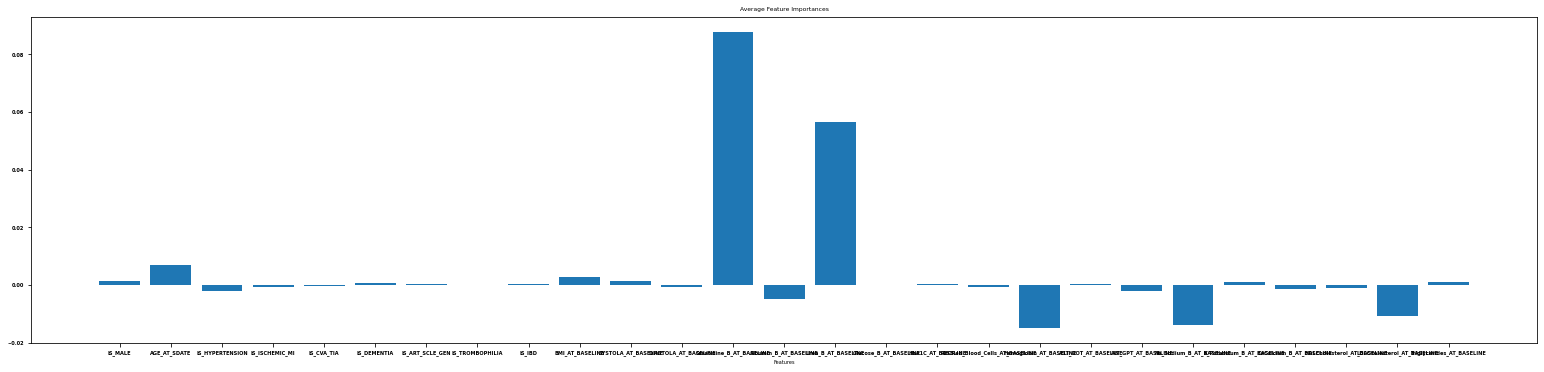

In [178]:
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 5}

matplotlib.rc('font', **font)

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(27,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
feature_names = [name for name in nums.columns[1:-3]]
visualize_importances(feature_names, np.mean(attr, axis=0))

It seems that Creatanine in the blood is the most correlated for this case,  after that Urea in the blood and then Sodium and Hemoglobin in the blood

In [179]:
cond = LayerConductance(model, model.seq[5])
cond_vals = cond.attribute((cont, cat0, cat1, cat2),target=0)
cond_vals = cond_vals.detach().numpy()

Average Neuron Importances
0 :  0.007
1 :  0.003
2 :  0.002
3 :  0.002
4 :  0.003
5 :  0.006
6 :  -0.000
7 :  -0.000
8 :  0.000
9 :  0.000
10 :  -0.000
11 :  0.010
12 :  -0.002
13 :  0.011
14 :  -0.001
15 :  0.006
16 :  0.012
17 :  0.001
18 :  0.001
19 :  0.008
20 :  -0.002
21 :  0.009
22 :  0.010
23 :  0.000
24 :  0.024


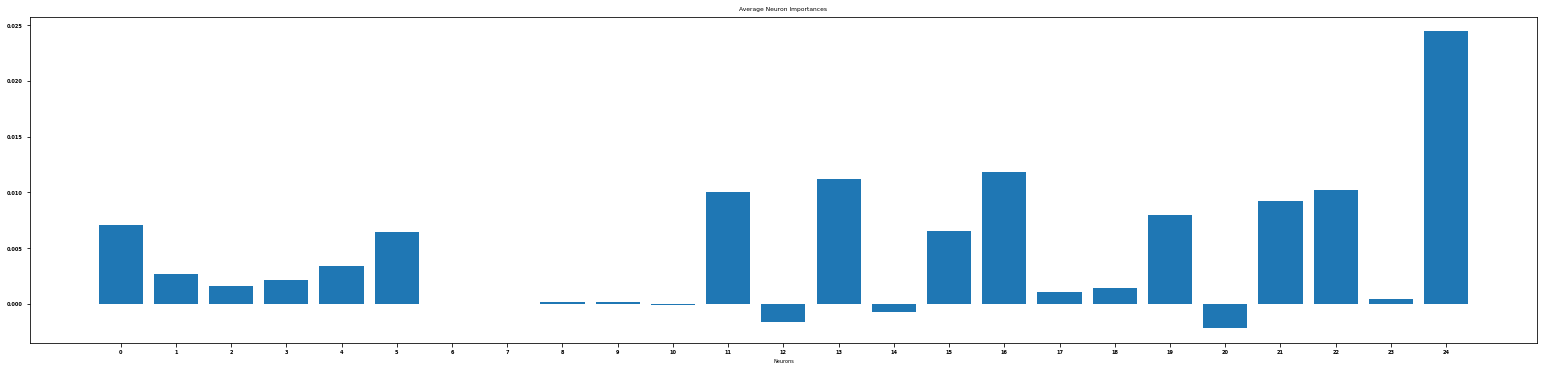

In [180]:
visualize_importances(range(25),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

We see that the last Neuron is the most meaningfull